The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0


# The Image Classification Dataset
:label:`sec_fashion_mnist`

(~~The MNIST dataset is one of the widely used dataset for image classification, while it's too simple as a benchmark dataset. We will use the similar, but more complex Fashion-MNIST dataset ~~)

One of the widely used dataset for image classification is the  [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) :cite:`LeCun.Bottou.Bengio.ea.1998` of handwritten digits. At the time of its release in the 1990s it posed a formidable challenge to most machine learning algorithms, consisting of 60,000 images of $28 \times 28$ pixels resolution (plus a test dataset of 10,000 images). To put things into perspective, at the time, a Sun SPARCStation 5 with a whopping 64MB of RAM and a blistering 5 MFLOPs was considered state of the art equipment for machine learning at AT&T Bell Laboratories in 1995. Achieving high accuracy on digit recognition was a key component in automating letter sorting for the USPS in the 1990s. Deep networks such as LeNet-5 :cite:`LeCun.Jackel.Bottou.ea.1995`, support vector machines with invariances :cite:`Scholkopf.Burges.Vapnik.1996`, and tangent distance classifiers :cite:`Simard.LeCun.Denker.ea.1998` all allowed to reach error rates below 1%. 

For over a decade, MNIST served as *the* point of reference for comparing machine learning algorithms. 
While it had a good run as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over 95%,
making it unsuitable for distinguishing between stronger models and weaker ones. Even more so, the dataset allows for *very* high levels of accuracy, not typically seen in many classification problems. This skewed algorithmic development towards specific families of algorithms that can take advantage of clean datasets, such as active set methods and boundary-seeking active set algorithms.
Today, MNIST serves as more of sanity checks than as a benchmark. ImageNet :cite:`Deng.Dong.Socher.ea.2009` poses a much 
more relevant challenge. Unfortunately, ImageNet is too large for many of the examples and illustrations in this book, as it would take too long to train to make the examples interactive. As a substitute we will focus our discussion in the coming sections on the qualitatively similar, but much smaller Fashion-MNIST
dataset :cite:`Xiao.Rasul.Vollgraf.2017`, which was released in 2017. It constains images of 10 categories of clothing at $28 \times 28$ pixels resolution.


In [1]:
%matplotlib inline
import time
import tensorflow as tf
from d2l import tensorflow as d2l

d2l.use_svg_display()

## Loading the Dataset

Since it is such a frequently used dataset, all major frameworks provide preprocessed versions of it. We can [**download and read the Fashion-MNIST dataset into memory using built-in framework functions.**]


In [2]:
class FashionMNIST(d2l.DataModule):  #@save
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.fashion_mnist.load_data()

Fashion-MNIST consists of images from 10 categories, each represented
by 6,000 images in the training dataset and by 1,000 in the test dataset.
A *test dataset* is used for evaluating model performance (it must not be used for training).
Consequently the training set and the test set
contain 60,000 and 10,000 images, respectively.


In [3]:
data = FashionMNIST(resize=(32, 32))
len(data.train[0]), len(data.val[0])

(60000, 10000)

The images are grayscale and upscaled to $32 \times 32$ pixels in resolution above. This is similar to the original MNIST dataset which consisted of (binary) black and white images. Note, though, that most modern image data which has 3 channels (red, green, blue) and hyperspectral images which can have in excess of 100 channels (the HyMap sensor has 126 channels).
By convention we store image as a $c \times h \times w$ tensor, where $c$ is the number of color channels, $h$ is the height and $w$ is the width.


In [4]:
data.train[0][0].shape

(28, 28)

[~~Two utility functions to visualize the dataset~~]

The categories of Fashion-MNIST have human-understandable names. 
The following convenience function converts between numeric labels and their names.


In [5]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the built-in data iterator rather than creating one from scratch.
Recall that at each iteration, a data iterator
[**reads a minibatch of data with size `batch_size`.**]
We also randomly shuffle the examples for the training data iterator.


In [6]:
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(
        self.batch_size).map(resize_fn).shuffle(shuffle_buf)

To see how this works, let's load a minibatch of images by invoking the newly-added `train_dataloader` method. It contains 64 images.


In [7]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 32, 32, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


Let's look at the time it takes to read the images. Even though it's a built-in loader, it isn't blazingly fast. Nonetheless, this is sufficient since processing images with a deep network takes quite a bit longer. Hence it's good enough that training a network won't be IO constrained.


In [8]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'0.82 sec'

## Visualization

We'll be using the Fashion-MNIST dataset quite frequently. A convenience function `show_images` can be used to visualize the images and the associated labels. Details of its implementation are deferred to the appendix.


In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    raise NotImplementedError

Let's put it to good use. In general, it is a good idea to visualize and inspect data that you're training on. 
Humans are very good at spotting unusual aspects and as such, visualization serves as an additional safeguard against mistakes and errors in the design of experiments. Here are [**the images and their corresponding labels**] (in text)
for the first few examples in the training dataset.


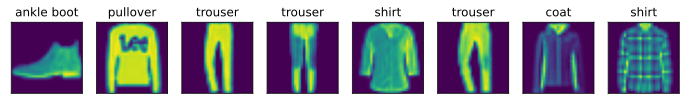

In [10]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X, nrows, ncols, titles=labels)

batch = next(iter(data.val_dataloader()))
data.visualize(batch)

We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

## Summary

We now have a slightly more realistic dataset to use for classification. Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various network designs, from a simple linear model to advanced residual networks. As we commonly do with images, we read them as a tensor of shape (batch size, number of channels, height, width). For now, we only have one channel as the images are grayscale (the visualization above use a false color palette for improved visibility). 

Lastly, data iterators are a key component for efficient performance. For instance, we might use GPUs for efficient image decompression, video transcoding, or other preprocessing. Whenever possible, you should rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.


## Exercises

1. Does reducing the `batch_size` (for instance, to 1) affect the reading performance?
1. The data iterator performance is important. Do you think the current implementation is fast enough? Explore various options to improve it. Use a system profiler to find out where the bottlenecks are.
1. Check out the framework's online API documentation. Which other datasets are available?


[Discussions](https://discuss.d2l.ai/t/224)
